# Tutorial: Out-of-sample Simulation

Here we simulate a trading strategy against several benchmarks. We perform the OHRP method with pre-defined in-sample window lenght $WL$ and optimal $(k,d)_{Opt}$ via the in-sample volatility minimization (in-sample grid search).

The benchamrks are the tradional de Prado's HRP, the RP (using risk budgeting and the Ledoit shrinkage) and the EW - as well as the the Brazilian Risk Free Rate (the SELIC) and the IBOVESPA stock market index.

This example uses YaHoo Finance data and is constraint to the IBOVESPA index composition so that its results may vary when compared against the published ones.

By Kevin Pergher, December the 24th, 2025.

In [1]:
import pandas
import datetime
import numpy
import warnings

warnings.filterwarnings("ignore")

from OHRP import OHRP
from HRP import HRP
from RP import RP
from EW import EW

# Extract the Dataset
X = pandas.read_csv('datasets/IBOV_equity_closing_prices.csv', index_col = 0, parse_dates=True)
X.index = pandas.to_datetime(X.index, format='%Y-%m-%d')

# Indices/Benchmarks
benchmarks = ['IBOV', 'SELIC']

Xindices = X[benchmarks].copy()

X.drop(columns=benchmarks, inplace = True)

# Separate Indices and Stocks
Xstocks = X.copy()
Xstocks.dropna(how='all', axis=0, inplace=True)
Xindices = Xindices.loc[Xstocks.index,:].copy()


In [11]:
# Time we want to start the rolling window
# Vary as you want or need
initialTime = 2600

# Available hyperparameters configurations
list_of_d = [5,10,15,20,25,30,35]
list_of_k = [1,3,5,7,9,11,13]

# Out of Sample Portfolio Returns
outSamplePortfolios = {
    "OHRP": pandas.Series(dtype = float),
    "HRP" : pandas.Series(dtype = float),
    "EW"  : pandas.Series(dtype = float),
    "RP"  : pandas.Series(dtype = float)
}
weights = {
    "OHRP": pandas.DataFrame(),
    "HRP" : pandas.DataFrame(),
    "EW"  : pandas.DataFrame(),
    "RP"  : pandas.DataFrame()
}

# Windows we want to test
for WL in [3.0]:

    print(f"Processing WL = {WL}")

    t  = initialTime

    # Convert window length in days
    windowLength = int(WL * 252)

    # How much day to hold the portfolio
    holdingPeriod = 42

    while t < (Xstocks.shape[0] - holdingPeriod):
        
        print(f"Processing t = {t} / {Xstocks.shape[0]}")
        
        # In-sample Data
        Xn = Xstocks.iloc[(t-windowLength):t,:].copy()
        # Out-of-sample Data
        Yn = Xstocks.iloc[t-1:t+holdingPeriod-1,:].copy()

        # Tickers with data on t
        activeFilter = ~pandas.isna(Xn.iloc[-1,:])
        activeFilter = activeFilter[activeFilter].index.tolist()
        Xn = Xn[activeFilter]
        Xn.dropna(axis = 0, how = 'all', inplace = True)
        Xn.dropna(axis = 1, thresh = int(0.9 * windowLength), inplace = True)
        Xn = Xn.pct_change().fillna(0)
        # Volatility filter - Some prices are manteined constant at YaHoo
        volatility = Xn.std(axis = 0)
        volatility = volatility[volatility > 0]
        Xn = Xn[volatility.index.tolist()]

        # Out-of-sample data
        Yn = Yn[Xn.columns.tolist()]
        Yn = Yn.pct_change().fillna(0)
        # Benchmark
        SELIC = Xindices.loc[Yn.index, 'SELIC'].copy()
        SELIC = SELIC.pct_change().fillna(0)
        # Drop first row (only zeros)
        Xn = Xn.iloc[1:,:].copy()
        Yn = Yn.iloc[1:,:].copy()
        SELIC = SELIC.iloc[1:].copy()

        # Perform OHRP
        ohrp = OHRP(codep = "pearson", linkage = "ward")
        weightsOHRP = ohrp.run(
            X = Xn.copy(), 
            k = list_of_k, 
            d = list_of_d, 
            r = [0.9]
        )

        # Perform HRP
        hrp = HRP(codep = "pearson", linkage = "ward")
        weightsHRP = hrp.run(
            X = Xn.copy()
        )

        # Perform RP
        rp = RP(method_cov="ledoit")
        weightsRP = rp.run(
            X = Xn.copy()
        )

        # Perform EW
        ew = EW()
        weightsEW = ew.run(
            X = Xn.copy()
        )

        # Out-of-sample Portfolio Returns
        outSamplePortfolioOHRP = (Yn * weightsOHRP).sum(axis = 1)
        outSamplePortfolioHRP  = (Yn * weightsHRP).sum(axis = 1)
        outSamplePortfolioRP   = (Yn * weightsRP).sum(axis = 1)
        outSamplePortfolioEW   = (Yn * weightsEW).sum(axis = 1)

        outSamplePortfolios["OHRP"] = pandas.concat(
            [outSamplePortfolios["OHRP"], outSamplePortfolioOHRP], axis = 0
        )
        outSamplePortfolios["HRP"] = pandas.concat(
            [outSamplePortfolios["HRP"], outSamplePortfolioHRP], axis = 0
        )
        outSamplePortfolios["RP"] = pandas.concat(
            [outSamplePortfolios["RP"], outSamplePortfolioRP], axis = 0
        )
        outSamplePortfolios["EW"] = pandas.concat(
            [outSamplePortfolios["EW"], outSamplePortfolioEW], axis = 0
        )

        # Weight
        weightsOHRP.name = t
        weightsHRP.name  = t
        weightsRP.name   = t
        weightsEW.name   = t

        weights["OHRP"] = pandas.concat(
            [weights["OHRP"], weightsOHRP],
            axis = 1
        )
        weights["HRP"] = pandas.concat(
            [weights["HRP"], weightsHRP],
            axis = 1
        )
        weights["RP"] = pandas.concat(
            [weights["RP"], weightsRP],
            axis = 1
        )
        weights["EW"] = pandas.concat(
            [weights["EW"], weightsEW],
            axis = 1
        )
    
        t += holdingPeriod

Processing WL = 3.0
Processing t = 2600 / 3928
Processing t = 2642 / 3928
Processing t = 2684 / 3928
Processing t = 2726 / 3928
Processing t = 2768 / 3928
Processing t = 2810 / 3928
Processing t = 2852 / 3928
Processing t = 2894 / 3928
Processing t = 2936 / 3928
Processing t = 2978 / 3928
Processing t = 3020 / 3928
Processing t = 3062 / 3928
Processing t = 3104 / 3928
Processing t = 3146 / 3928
Processing t = 3188 / 3928
Processing t = 3230 / 3928
Processing t = 3272 / 3928
Processing t = 3314 / 3928
Processing t = 3356 / 3928
Processing t = 3398 / 3928
Processing t = 3440 / 3928
Processing t = 3482 / 3928
Processing t = 3524 / 3928
Processing t = 3566 / 3928
Processing t = 3608 / 3928
Processing t = 3650 / 3928
Processing t = 3692 / 3928
Processing t = 3734 / 3928
Processing t = 3776 / 3928
Processing t = 3818 / 3928
Processing t = 3860 / 3928


See te final out-of-sample portfolios and add the indices

In [12]:
#Xindices
outSampleCumPortfolios = pandas.concat([outSamplePortfolios[key] for key in outSamplePortfolios.keys()], axis=1)
outSampleCumPortfolios.columns = outSamplePortfolios.keys()

refIndices = Xindices.loc[outSampleCumPortfolios.index, :].copy()
refIndices = refIndices.pct_change().fillna(0)

outSampleCumPortfolios = pandas.concat([outSampleCumPortfolios, refIndices], axis=1)

outSampleCumPortfolios = (1 + outSampleCumPortfolios).cumprod()

outSampleCumPortfolios

,OHRP,HRP,EW,RP,IBOV,SELIC
2020-06-26,0.988755,0.979681,0.976421,0.978815,1.000000,1.000000
2020-06-29,0.995611,0.994523,0.994364,0.994403,1.020259,1.000084
2020-06-30,0.999718,0.994281,0.993680,0.993211,1.013023,1.000169
2020-07-01,1.013963,1.005625,1.005520,1.004420,1.025247,1.000253
2020-07-02,1.008894,1.003307,1.003131,1.001385,1.025588,1.000338
...,...,...,...,...,...,...
2025-09-09,1.704699,1.757860,1.709311,1.718819,1.509240,1.626152
2025-09-10,1.706609,1.759992,1.714530,1.721587,1.517030,1.627049
2025-09-11,1.705462,1.768575,1.729546,1.733130,1.525577,1.627946
2025-09-12,1.698134,1.761535,1.719346,1.723982,1.516209,1.628843


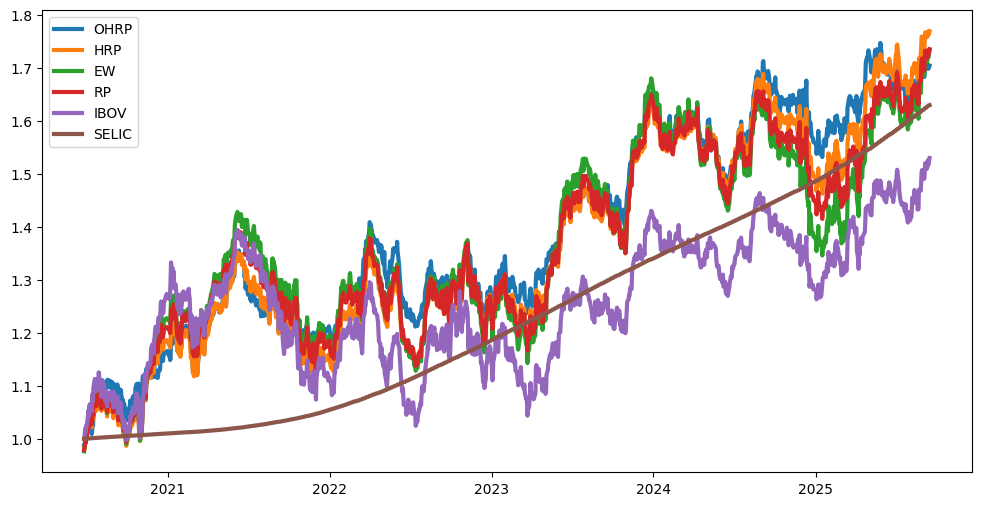

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
for column in outSampleCumPortfolios.columns:
    plt.plot(outSampleCumPortfolios.index, outSampleCumPortfolios[column], label=column, lw = 3)
plt.legend()
plt.show()

Visualize the weight vector

In [18]:
weights["OHRP"].fillna(0).transpose()

,ABEV3,AZZA3,B3SA3,BBSE3,BBDC3,BBDC4,BRAP4,BBAS3,BRKM5,BPAC11,...,RDOR3,CMIN3,VAMO3,ASAI3,CXSE3,RECV3,RAIZ4,SMFT3,IGTI11,AURE3
2600,0.021063,0.001323,0.001520,0.002296,0.001108,0.001075,0.001541,0.001059,0.007528,0.001721,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2642,0.034329,0.005973,0.003990,0.012384,0.002803,0.002926,0.007850,0.002611,0.004164,0.003214,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2684,0.023588,0.000618,0.001153,0.001390,0.000363,0.000353,0.000628,0.000556,0.001854,0.000731,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2726,0.039801,0.006222,0.004140,0.017598,0.002463,0.002038,0.007838,0.003323,0.002431,0.002646,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2768,0.064837,0.004042,0.008452,0.012427,0.003654,0.003685,0.006767,0.004880,0.001795,0.005351,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2810,0.031695,0.005697,0.008569,0.039923,0.006642,0.006997,0.004321,0.005485,0.003632,0.004348,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2852,0.025572,0.004796,0.007323,0.016358,0.004544,0.004543,0.019238,0.004070,0.003832,0.003458,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2894,0.011581,0.006926,0.007726,0.018221,0.002542,0.002484,0.012539,0.002697,0.003526,0.004073,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2936,0.019984,0.004784,0.007019,0.023243,0.002664,0.002564,0.009145,0.004017,0.003183,0.003754,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2978,0.026640,0.003857,0.005773,0.024820,0.005685,0.005554,0.009663,0.005036,0.004384,0.003087,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
